# Analizado Datos de Yelp con Neo4j

[Yelp](https://www.yelp.com/) ayuda a las pesonas a encontrar negocios locales con base en reseñas, preferencias y recomendaciones. Alrededor de 180 millones de reseñas han sido escritas en la plataforma a finales de 2018. Desde 2013, Yelp ha lanzado el [Yelp Dataset Challenge](https://www.yelp.com/dataset/challenge), una competencia que anima a las personas a explorar e investigar el conjunto de datos abierto de Yelp.

En la Ronda 12 (2018) del reto, el conjunto de datos contenía:
* Acerca de 7 millones de reseñas.
* Más de 1.5 millones de usuarios y 280,000 imágenes.
* Más de 188,000 empresas con 1.4 millones de características.
* 10 áreas metropolitanas.

Los usuarios de Yelp forman una red social. Los usuarios pueden enviar solicitud de amistad a otros con los que se han encontrado mientras navegan por su página web, conectar sus libretas de direcciones o Facebook.

# Objetivo
Explorar los datos de Yelp para ayudar a los usuarios a planificar sus viajes. 


# Índice

* Importación de Datos.
* Descripción rápida de los datos.
* Recomendaciones de Restaurantes.
* Promociones Cruzadas.
* Referencias

# Importación de Datos

La herramienta de importación de Neo4j procesa CSV con una estructura específica (Figura 1). La información de Yelp está en formato JSON, de modo que primero será neceasrio convertirlos en el formato esperado (Figura 2). Usando Python, podemos crear un script the python para convertir los datos en un archivo CSV. 
<center>
<img src="figures/Fig1.png" alt="Formato-CSV" width="480">
Figura 1. Formato de archivos CSV para el proceso de importación en Neo4j.
<img src="figures/Fig2.png" alt="JSON-to-CSV" width="480">
Figura 2. Transformación JSON a CSV.
</center>

Instrucciones "detalladas" pueden encontrarse en el siguiente [enlace](https://github.com/mneedham/yelp-graph-algorithms). Sin embargo, el conjunto de datos es considerablemente grande. Debido a esto Neo4j ha creado un sandbox para analizar los datos (2018).

Cree un sandbox en el siguiente [enlace](https://neo4j.com/sandbox-v2-dev/), y seleccione el "Yelp Public Dataset". 

La conexión al ambiente sandbox puede obtenerse mediante la siguiente sintaxis:

```python
user = "user"
password = "password"
driver = GraphDatabase.driver("bolt://<IP Address>:<Bolt Port>", auth=(user, password))
````

Consulta las Figura 3 para mayor detalle.


<center>
<img src="figures/Fig3.png" alt="Sandbox-conexion" width="480">
Figura 3. Conexión con el sandbox.
</center>



In [36]:
# Importación de Bibliotecas
from neo4j import GraphDatabase
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
# Credenciales del Neo4j Sandbox

user = "neo4j"
#user = "<users>"

password = "buoy-blowers-scene"
#password = "<password>"

driver = GraphDatabase.driver("bolt://3.229.255.49:32834", auth=(user, password))
#driver = "GraphDatabase.driver("bolt://<IP Address>:<Bolt Port>", auth = (user, password))"

Una vez que han sido cargados los datos a Neo4j es posible ejecutar consultas exploratorias.

# Descripción rápida de los datos


In [39]:
# Conteo del número de nodos por cada etiqueta en la base de datos

result = {"label": [], "count": []}
with driver.session() as session:
    labels = [row["label"] for row in session.run("CALL db.labels()")]
    for label in labels:
        query = f"MATCH (:`{label}`) RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["label"].append(label)
        result["count"].append(count)
df = pd.DataFrame(data=result)
df.sort_values("count", ascending=False)

,label,count
3,Review,677379
2,User,330678
5,Photo,30780
0,Business,27455
7,Reviewer,17204
6,Label,2542
1,Category,1142
8,SuperCategory,163
4,City,2


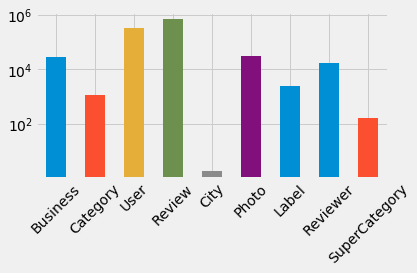

In [40]:
# Representación visual del conteo del número de nodos por cada etiqueta en la base de datos

plt.style.use('fivethirtyeight')
ax = df.plot(kind='bar', x='label', y='count', legend=None)
ax.xaxis.set_label_text("")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Realicemos un análisis similar para los tipos de relaciones.

In [42]:
# Conteo del número de registros por cada tipo de relación en la base de datos

result = {"relType": [], "count": []}
with driver.session() as session:
    rel_types = [row["relationshipType"] for row in session.run
    ("CALL db.relationshipTypes()")]
    for rel_type in rel_types:
        query = f"MATCH ()-[:`{rel_type}`]->() RETURN count(*) as count"
        count = session.run(query).single()["count"]
        result["relType"].append(rel_type)
        result["count"].append(count)
df = pd.DataFrame(data=result)
df.sort_values("count", ascending=False)

,relType,count
1,FRIENDS,1208624
2,WROTE,677379
8,HAS_LABEL,250020
3,REVIEWS,115847
0,IN_CATEGORY,111731
6,WROTE_TIP,75949
5,HAS_PHOTO,30780
4,IN_CITY,27455
9,SIMILAR,1936
7,NARROWER_THAN,1499


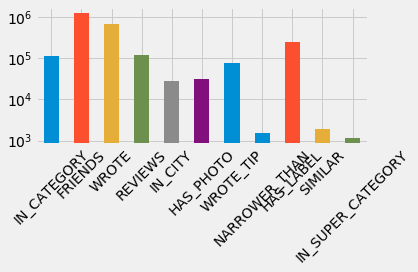

In [43]:
# Representación visual del conteo del número de registros por cada tipo de relación en la base de datos


plt.style.use('fivethirtyeight')
ax = df.plot(kind='bar', x='relType', y='count', legend=None)
ax.xaxis.set_label_text("")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Encontremos las categorías más populares basadas en el número de reseñas en los negocios.

In [48]:
query = """
MATCH (category:Category)
RETURN category.name AS category,
       size((category)<-[:IN_CATEGORY]-()) AS businesses,
       size((:Review)-[:REVIEWS]->(:Business)-[:IN_CATEGORY]->(category)) AS reviews
ORDER BY reviews DESC
LIMIT 10
"""

with driver.session() as session:
    rows = session.run(query)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,businesses,category,reviews
0,5341,Restaurants,62002
1,2793,Food,22005
2,1307,Nightlife,20832
3,1150,Bars,19887
4,620,Breakfast & Brunch,13861
5,673,American (New),13667
6,740,American (Traditional),11706
7,880,Mexican,10262
8,3016,Beauty & Spas,9794
9,4608,Shopping,9734


La categoría "Restaurants" puede ser una buena opción para analizar, ya que esta tiene muchos negocios y cantidad de reseñas para trabajar.

In [52]:
query = """
MATCH (category:Category {name: "Restaurants"})
RETURN size((category)<-[:IN_CATEGORY]-()) AS businesses,
    size((:Review)-[:REVIEWS]->(:Business)-[:IN_CATEGORY]-> (category)) AS reviews
"""

with driver.session() as session:
    rows = session.run(query)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,businesses,reviews
0,5341,62002


# Recomendaciones de Restaurante

Encontremos los restaurantes mejor calificados como una heurísticas para las opciones populares de reservas. Podemos agregar qué tan bien han sido calificados para comprender mejor la información. Note que el eje x de las gráficas representan la calificación de los restaurantes y el eje y el porcentaje de cada calificación.

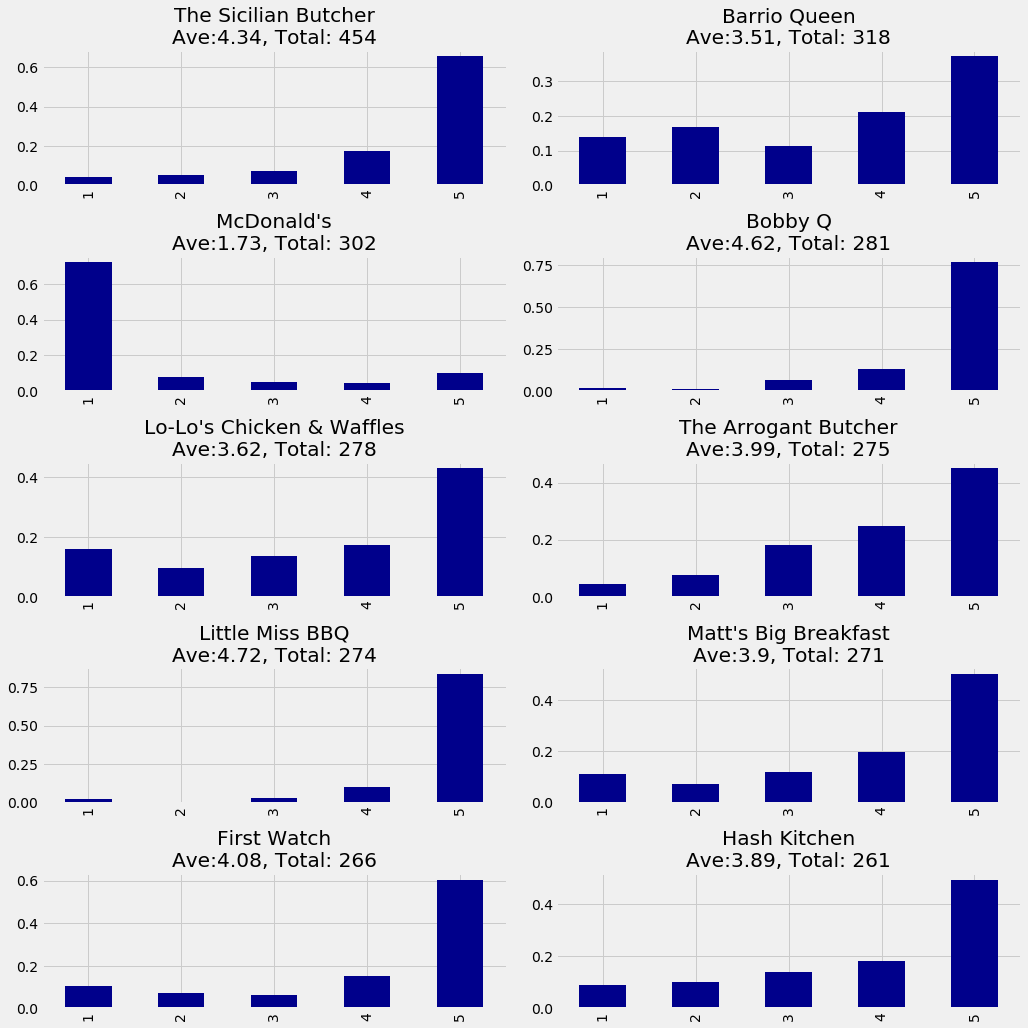

In [60]:
# Find the 10 hotels with the most reviews
query = """
MATCH (review:Review)-[:REVIEWS]->(business:Business),
      (business)-[:IN_CATEGORY]->(category:Category {name: $category})
RETURN business.name AS business, collect(review.stars) AS allReviews
ORDER BY size(allReviews) DESC
LIMIT 10
"""

fig = plt.figure()
fig.set_size_inches(14.5, 14.5)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

params = {"category": "Restaurants"}

with driver.session() as session:    
    result = session.run(query, params)
    for index, row in enumerate(result):
        business = row["business"]
        stars = pd.Series(row["allReviews"])
        total = stars.count()
        average_stars = stars.mean().round(2)
        
        # Calculate the star distribution
        stars_histogram = stars.value_counts().sort_index()
        stars_histogram /= float(stars_histogram.sum())
        
        # Plot a bar chart showing the distribution of star ratings
        ax = fig.add_subplot(5, 2, index+1)
        stars_histogram.plot(kind="bar", legend=None, color="darkblue",
        title=f"{business}\nAve:{average_stars}, Total: {total}")
plt.tight_layout()
plt.show()

Los restaurantes anteriores tienen muchas críticas. Sin embargo, sería mejor mostrar el contenido de las revisiones más relevantes. 

Una forma en la que puede decidirse cuales reseñas postear es ordenándolos con base en la influencia de los usuarios que hacen reseñas en Yelp. El algoritmos PageRank puede ejecutarse sobre el grafo proyectado de los usuarios que tienen al menos tres reseñas. Las características por defecto son 0.85 de factor de amortiguamiento (*damping factor*) y 20 iteraciones máximas.

<center>
<img src="figures/Fig4.png" alt="sample-Yelp-graph" width="720">
Figura 4. Muestra del grafo de Yelp.
<img src="figures/Fig5.png" alt="projected-graph" width="480">
Figura 5. Grafo proyectado de la muestra en la Figura 4.
</center>


In [18]:
query = """
CALL algo.pageRank(
  'MATCH (u:User)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->
         (:Category {name: $category})
   WITH u, count(*) AS reviews
   WHERE reviews >= $cutOff
   RETURN id(u) AS id',
  'MATCH (u1:User)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->
         (:Category {name: $category})
   MATCH (u1)-[:FRIENDS]->(u2)
   RETURN id(u1) AS source, id(u2) AS target',{ 
     graph: "cypher", 
     write: true, 
     writeProperty: $writeProperty,
     params: {category: $category, cutOff: $cutOff}
  })
"""

params = {
    "category": "Restaurants",
    "writeProperty": "restaurantPageRank",
    "cutOff": 3
}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,computeMillis,dampingFactor,iterations,loadMillis,nodes,write,writeMillis,writeProperty
0,115,0.85,20,2019,4563,True,200,restaurantPageRank


Observemos la distribución de los valores del PageRank.

In [19]:
query = """
MATCH (u:User)
WHERE not(u[$prop] is null)
RETURN count(u[$prop]) AS count,
       avg(u[$prop]) AS ave,
       percentileDisc(u[$prop], 0.5) AS `50%`,
       percentileDisc(u[$prop], 0.75) AS `75%`,
       percentileDisc(u[$prop], 0.90) AS `90%`,
       percentileDisc(u[$prop], 0.95) AS `95%`,
       percentileDisc(u[$prop], 0.99) AS `99%`,
       percentileDisc(u[$prop], 0.999) AS `99.9%`,
       percentileDisc(u[$prop], 0.9999) AS `99.99%`,
       percentileDisc(u[$prop], 0.99999) AS `99.999%`,
       percentileDisc(u[$prop], 1) AS `100%`
"""

params = {"prop": "restaurantPageRank"}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df) 

,100%,50%,75%,90%,95%,99%,99.9%,99.99%,99.999%,ave,count
0,40.693077,0.15,0.334138,0.957964,1.408705,4.835771,11.586864,40.693077,40.693077,0.449748,4563


El 50% de los usuarios tiene un PageRank menor a 0.15, el cual es el valor en el cual se inicializa el algoritmo. Los datos reflejan una distribución de ley de potencias con un conjunto pequeño de usuarios influyentes. Debido a que solo se quiere encontrar a los usuarios más influyentes, la siguiente petición encuentra el top 1% de todos los usuarios con base en el PageRank. Esto corresponde a que los usuarios deben tener más de 4.54.

In [61]:
query = """
// Only find users that have a score in the top 1% of users
MATCH (u:User)
WHERE u[$prop] > $score

// Find the top 10 of those users
WITH u ORDER BY u[$prop] DESC
LIMIT 10
RETURN u.name AS name,
       u[$prop] AS pageRank,
       size((u)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {name: $category})) AS restReviews,
       size((u)-[:WROTE]->()) AS totalReviews,
       size((u)-[:FRIENDS]-()) AS friends
"""

params = {
    "prop": "restaurantPageRank", 
    "category": "Restaurants",
    "score": 4.54
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,friends,name,pageRank,restReviews,totalReviews
0,2401,Joyce,40.693077,6,72
1,1629,Hailey,24.333993,27,55
2,954,Brittany,13.396207,10,18
3,914,Stephen,12.113862,7,19
4,696,Ria,11.586864,5,19
5,834,Rick,10.687355,6,19
6,956,Jay,10.330206,8,23
7,830,Simon,10.256998,7,30
8,1267,Juan,9.898372,7,62
9,828,Monica,9.676527,12,32


Los restaurantes requieren estar alerta cuando un visitante influyente escribe acerca de su estancia de manera que puedan tomar acciones necesarias. A continuación se presentan las calificaciones del "The Sicilian Butcher", ordenadas por los usuarios más influyentes.

In [63]:
 query = """
MATCH (b:Business {name: $business})
MATCH (b)<-[:REVIEWS]-(review)<-[:WROTE]-(user)
WHERE not(user[$prop] is null)
RETURN user.name AS name,
       user[$prop] AS pageRank,
       review.stars AS stars
"""

params = {
    "business": "The Sicilian Butcher",
    "prop": "restaurantPageRank"
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])
    df = df.round(2)
    df = df[["name", "pageRank", "stars"]]

top_reviews = df.sort_values(by=["pageRank"], ascending=False).head(10)
top_reviews

,name,pageRank,stars
106,Georgie,8.33,3
120,Jessica,6.13,1
111,Ashley,5.72,5
82,Yuko,4.59,4
7,Cindy,4.14,3
81,Bonnie,3.93,3
2,Dwayne,2.89,4
77,Louis,2.72,5
108,Jennifer,2.66,5
44,Ashley,2.33,5


Jessica tiene un Pagerank alto, de modo que se encuentran entre los usuarios más influyentes pero no ha pasado un buen tiempo en el restaurante. De modo que puede justificarse un acercamiento personal por parte del restaurante. 

# Promociones Cruzadas

Después de encontrar los usuarios más influyentes, identifiquemos negocios para hacer promociones cruadas con ayuda de los usuarios mejor conectados para "The Sicilian Butcher". El *betweenness centrality* permite identificar los usuarios que están mejor conectados en la red y que actúan como puentes entre diferentes grupos. Una etiqueta será añadida a todos aquellos usuarios que han escrito más de 5 reseñas.

In [67]:
# Etiquetado de los usuarios con más de 5 reseñas
query = """
MATCH (u:User)
WHERE size((u)-[:WROTE]->()) > 5
SET u:Reviewer
"""

with driver.session() as session:
    result = session.run(query, params)
    display(result.summary().counters)

{}

In [69]:
# Cálculo del Between Centrality
query = """
CALL algo.betweenness('Reviewer', 'FRIENDS', {
  write: true, 
  writeProperty: $prop
})
"""

params = {
    "prop": "between"
}

with driver.session() as session:    
    rows = session.run(query, params)
    display(rows.summary().counters)

{}

Las calificaciones siguen la siguiente distribución entre los usuarios.

In [70]:
query = """
MATCH (u:User)
WHERE not(u[$prop] is null)
RETURN count(u[$prop]) AS count,
       avg(u[$prop]) AS ave,
       percentileDisc(u[$prop], 0.5) AS `50%`,
       percentileDisc(u[$prop], 0.75) AS `75%`,
       percentileDisc(u[$prop], 0.90) AS `90%`,
       percentileDisc(u[$prop], 0.95) AS `95%`,
       percentileDisc(u[$prop], 0.99) AS `99%`,
       percentileDisc(u[$prop], 0.999) AS `99.9%`,
       percentileDisc(u[$prop], 0.9999) AS `99.99%`,
       percentileDisc(u[$prop], 0.99999) AS `99.999%`,
       percentileDisc(u[$prop], 1) AS `100%`
"""

params = {"prop": "between"}

with driver.session() as session:    
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df) 

,100%,50%,75%,90%,95%,99%,99.9%,99.99%,99.999%,ave,count
0,9.921710e+06,0.0,159.824481,17320.0,30922.294869,152732.109096,1.300869e+06,7.022190e+06,9.921710e+06,11502.415834,17204


La mitad de los usuarios tienen una calificación de 0, indicando que no están bien conectados. El top 1 percentil (99%) se encuentra en al menos 150,000 caminos más cortos (*shortest path*). 

In [71]:
query = """
MATCH(u:User)-[:WROTE]->()-[:REVIEWS]->(:Business {name: $business})
WHERE not(u[$prProp] is null) AND not(u[$bwProp] is null)
RETURN u.name AS user,
       toInteger(u[$bwProp]) AS betweenness,
       u[$prProp] AS pageRank,
       size((u)-[:WROTE]->()-[:REVIEWS]->()-[:IN_CATEGORY]->(:Category {name: $category})) AS hotelReviews
ORDER BY u[$bwProp] DESC
LIMIT 10
"""

params = {
    "business": "The Sicilian Butcher",
    "prProp": "restaurantPageRank",
    "bwProp": "between",
    "category": "Restaurants"
}

with driver.session() as session:
    rows = session.run(query, params)

df = pd.DataFrame([dict(record) for record in rows])
df = df.round(2)
df 

,betweenness,hotelReviews,pageRank,user
0,477863,21,8.33,Georgie
1,237056,13,4.59,Yuko
2,120057,7,6.13,Jessica
3,107986,23,3.93,Bonnie
4,83116,24,2.89,Dwayne
5,76923,17,4.14,Cindy
6,68347,39,2.66,Jennifer
7,53509,8,5.72,Ashley
8,51953,23,0.89,Rebecca
9,42709,5,1.21,Erika


Algunos de los usuarios son los mismo que en el análisis de PageRank. Rebecca y Erika a pesar de tener un bajo PageRank parecen ser influyentes en la red. 

En el esfuerzo por llegar a una mayor variedad de clientes, se analizarán otras preferencias de estos "conectores" para ver lo que debe ser promocionado. Muchos de estos usuarios también han escrito acerca de bares o vida nocturna.

In [72]:
query = """
// Find the top 50 users who have reviewed the Sicilian Butcher
MATCH (u:User)-[:WROTE]->()-[:REVIEWS]->(:Business {name:$business})
WHERE not(u[$prop] is null) AND u[$prop] > 0
WITH u ORDER BY u[$prop] DESC LIMIT 50

// Find the bars and nightlife those users have reviewed in Las Vegas
MATCH (u)-[:WROTE]->(review)-[:REVIEWS]-(business)
WHERE any(cat in $categories WHERE (business)-[:IN_CATEGORY]->(:Category {name: cat})) 

// Only include businesses that have more than 3 reviews by these users
WITH business, avg(review.stars) AS averageReview, count(*) AS numberOfReviews
WHERE numberOfReviews >= 3
RETURN business.name AS business, averageReview, numberOfReviews,
       [(business)-[:IN_CATEGORY]->(cat) | cat.name] AS categories
ORDER BY averageReview DESC, numberOfReviews DESC
LIMIT 10
"""

params = {
    "business": "The Sicilian Butcher",
    "prop": "between",
    "categories": ["Nightlife", "Bars"]
}

with driver.session() as session:
    rows = session.run(query, params)
    df = pd.DataFrame([dict(record) for record in rows])

display(df)

,averageReview,business,categories,numberOfReviews
0,4.750000,Mowry & Cotton,"[Food, Cocktail Bars, Restaurants, Nightlife, ...",4
1,4.666667,The Covenant,"[Coffee & Tea, Breakfast & Brunch, American (N...",3
2,4.000000,The Porch,"[American (New), Southern, Restaurants, Nightl...",6
3,3.800000,Shake Shack,"[Hot Dogs, Fast Food, Wine & Spirits, Beer, Am...",5
4,3.571429,Barrio Queen,"[Mexican, Restaurants, Food, Nightlife, Bars, ...",7
5,3.250000,Cold Beers & Cheeseburgers - Paradise Valley,"[Restaurants, Bars, Nightlife, Burgers, Americ...",4
6,2.333333,Z'Tejas Southwestern Grill,"[Food, Tex-Mex, Nightlife, Restaurants, Bars, ...",3


De modo que el "The Sicilian Butcher" debería llevar a cabo una promoción conjunta con esos bares o club nocturnos para atraer nuevos clientes de grupos que normalmente no llegan

Notebook basada en *Graph Algorithms. Practical Examples in Apache Spark & Neo4j. Chapter 7. Graph Algorithms in Practice*.

# Referencias

* Needham M., Hodler Amy E. (2019). Graph Algorithms. Practical Examples in Apache Spark & Neo4j. O'Reailly.
* Graph Algorithms in Practice. [Module 5](https://resources.oreilly.com/learning-paths/graph-algorithms-in-practice/blob/master/notebooks/Module5.ipynb).
